In [1]:
import sys
import os

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics


import torch

from myutils import number_split, create_mix, training_with_CS

from src.MultiLabel import TransformerDataset, MultiLabel
from src.MultiClassificationNN import MultiClassificationNN
from src.BinaryClassificationNN import BinaryClassificationNN

In [3]:
import seaborn as sns

In [4]:
## Model Configurations
num_labels = 2


pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 10
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 30


lr = 1e-6
grad_norm = 1.0
balance_weights = False

model_config = {}
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

### Healthy DB

In [34]:
df = pd.read_csv('./processed_db.csv', index_col=0)
df_wls = df[df['source'] == 0]
df_pitts = df[df['source'] == 1]

- Get valid number settings

In [42]:
n_test = 150

# use C_z and C_y ratio from raw dataset

p_wls = (df_wls.gender.value_counts()/len(df_wls))[1]
p_pitts = (df_pitts.gender.value_counts()/len(df_pitts))[1]
p_z1_mix = (df.source.value_counts()/len(df))[1]


# p_wls = 0.54
# p_pitts = 0.64
# p_z1_mix = 0.18

valid_full_settings = []
for combination in itertools.product([p_wls], 
                                    [p_pitts], 
                                     np.arange(0.1,0.6, 0.1),
                                     np.arange(0.1, 4, 0.1), #range alpha from 0 to 4
                                     [4], # train/test ratio
                                     [n_test],
                                    ):
    
    res = number_split(p_pos_train_z0=combination[0], 
                       p_pos_train_z1 = combination[1], 
                       p_mix_z1 = combination[2], alpha_test = combination[3],
                       train_test_ratio = combination[4], 
                       n_test=n_test)
    
    if res is not None:
        valid_full_settings.append(res)

Invalid sample numbers  n_z1_neg_train: 22 n_z0_neg_train: 249 n_z1_neg_test: 0 n_z0_neg_test: 68
Invalid test set probability P(Y=1|Z=0):0.4952085754712787, P(Y=1|Z=1):1.0399380084896854
Invalid test set probability P(Y=1|Z=0):0.4907870703331423, P(Y=1|Z=1):1.0797315547329132
Invalid test set probability P(Y=1|Z=0):0.48644382192311447, P(Y=1|Z=1):1.1188207904231635
Invalid test set probability P(Y=1|Z=0):0.4821767708536135, P(Y=1|Z=1):1.1572242500486725
Invalid test set probability P(Y=1|Z=0):0.4779839293679299, P(Y=1|Z=1):1.1949598234198249
Invalid test set probability P(Y=1|Z=0):0.4738633782526891, P(Y=1|Z=1):1.2320447834569916
Invalid test set probability P(Y=1|Z=0):0.46981326390864914, P(Y=1|Z=1):1.2684958125533528
Invalid test set probability P(Y=1|Z=0):0.46583179557044013, P(Y=1|Z=1):1.3043290275972326
Invalid test set probability P(Y=1|Z=0):0.4619172426664869, P(Y=1|Z=1):1.3395600037328121
Invalid test set probability P(Y=1|Z=0):0.4580679323109328, P(Y=1|Z=1):1.3742037969327985

### Create corresponding datasets and run the model

In [49]:
valid_full_settings

[{'n_train': 600,
  'n_test': 150,
  'n_z0_pos_train': 291,
  'n_z0_neg_train': 249,
  'n_z0_pos_test': 82,
  'n_z0_neg_test': 53,
  'n_z1_pos_train': 38,
  'n_z1_neg_train': 22,
  'n_z1_pos_test': 1,
  'n_z1_neg_test': 14,
  'mix_param_dict': {'p_pos_train_z0': 0.539756782039289,
   'p_pos_train_z1': 0.6390041493775933,
   'p_pos_train': 0.5496815187731194,
   'p_pos_test': 0.5496815187731194,
   'p_mix_z0': 0.9,
   'p_mix_z1': 0.1,
   'alpha_train': 1.1838742386215724,
   'alpha_test': 0.1,
   'p_pos_test_z0': 0.6040456250254059,
   'p_pos_test_z1': 0.060404562502540594,
   'C_y': 0.5496815187731194,
   'C_z': 0.1}},
 {'n_train': 600,
  'n_test': 150,
  'n_z0_pos_train': 291,
  'n_z0_neg_train': 249,
  'n_z0_pos_test': 81,
  'n_z0_neg_test': 54,
  'n_z1_pos_train': 38,
  'n_z1_neg_train': 22,
  'n_z1_pos_test': 2,
  'n_z1_neg_test': 13,
  'mix_param_dict': {'p_pos_train_z0': 0.539756782039289,
   'p_pos_train_z1': 0.6390041493775933,
   'p_pos_train': 0.5496815187731194,
   'p_pos_te

In [7]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['full_setting']=[]
losses_dict['losses'] = []
losses_dict['auroc'] = []
losses_dict['auprc'] = []
losses_dict['acc'] = []

random.seed(2023)

In [41]:
len(valid_full_settings)

97

In [39]:
two_df = [df_wls, df_pitts]

In [69]:
metrics_dict_mix

{'full_setting': [],
 'losses': [[0.6813424229621887,
   0.6776170134544373,
   0.6779354810714722,
   0.6832827925682068,
   0.6722555756568909],
  [0.6770241856575012,
   0.675733745098114,
   0.6826263666152954,
   0.6799933910369873,
   0.6897386908531189],
  [0.6810699701309204,
   0.6778510808944702,
   0.6827747821807861,
   0.6750696301460266,
   0.6840000152587891],
  [0.6805408000946045,
   0.6781103014945984,
   0.6751490235328674,
   0.6917806267738342,
   0.6734493970870972],
  [0.6813730597496033,
   0.6846581101417542,
   0.6816049814224243,
   0.6786432266235352,
   0.6788355708122253],
  [0.6832696199417114,
   0.6806458234786987,
   0.6823353171348572,
   0.6863483786582947,
   0.6699270606040955],
  [0.685111403465271,
   0.6788288950920105,
   0.6832278370857239,
   0.6784708499908447,
   0.678428590297699],
  [0.681847095489502,
   0.6881673336029053,
   0.6789010167121887,
   0.683350145816803,
   0.6748013496398926],
  [0.6780114769935608,
   0.6851816773414612,


In [ ]:
cs_db = training_with_CS(DNmodel=BinaryClassificationNN, settings_list = valid_full_settings, 
                               df = two_df, target = 'gender', lossf=torch.nn.NLLLoss, 
                                average = 'macro', sample=True, config= model_config)

Training different combinations:   0%|          | 0/135 [00:00<?, ?it/s]

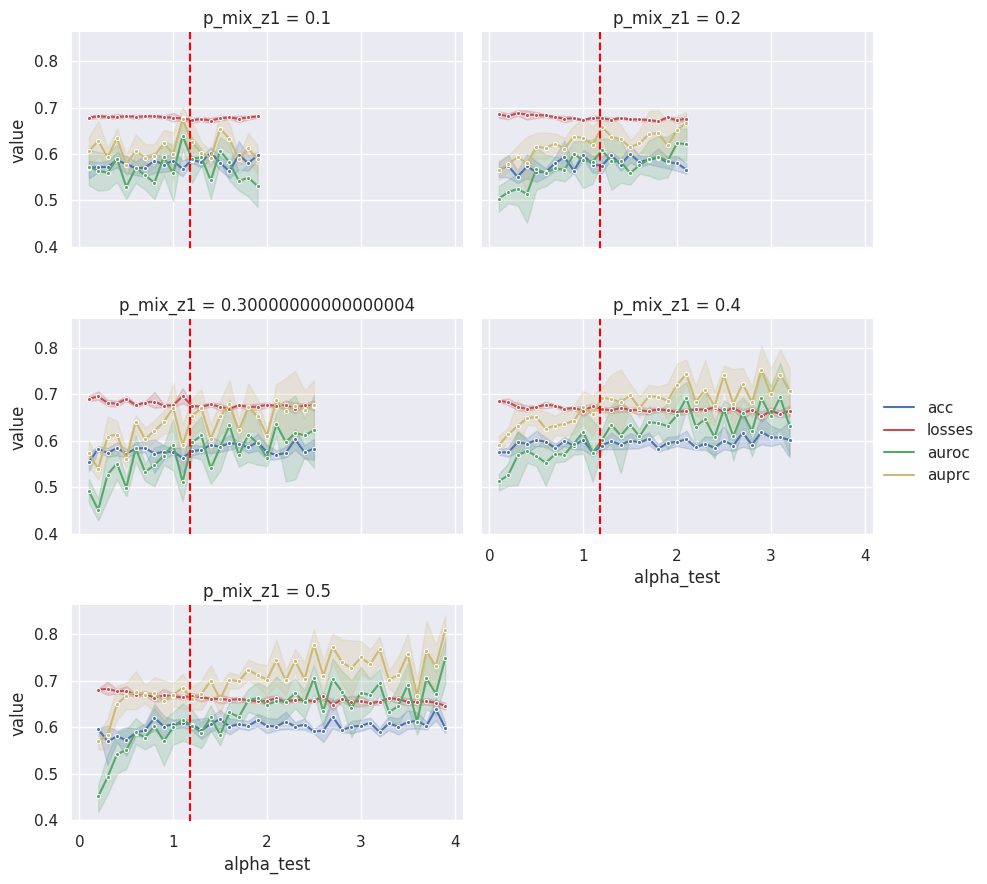

In [70]:
tmp = plot_CS(loss_dict=metrics_dict_mix, logx = False)
pass

### Fisher 

In [4]:
df_fisher = pd.read_csv('./processed_fisher.tsv', index_col=0, sep = '\t')

In [13]:
df_fisher_us = df_fisher.loc[df_fisher["WHERE_RAISED"].str.len()==2]
df_fisher_us.loc[:,'gender'] = df_fisher_us['S_SEX'].copy().map({'M':0, 'F':1})
df_fisher_us.loc[:,'source'] = df_fisher_us['WHERE_RAISED'].map({'MA': 0, 'GA': 1})
df_ma = df_fisher_us.loc[df_fisher["WHERE_RAISED"] == 'MA']
df_ga = df_fisher_us.loc[df_fisher["WHERE_RAISED"] == 'GA']

/tmp/ipykernel_54803/3266369418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fisher_us.loc[:,'gender'] = df_fisher_us['S_SEX'].copy().map({'M':0, 'F':1})
/tmp/ipykernel_54803/3266369418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fisher_us.loc[:,'source'] = df_fisher_us['WHERE_RAISED'].map({'MA': 0, 'GA': 1})


In [14]:
df_ns = pd.concat([df_ga, df_ma], axis = 0)

In [16]:
n_test = 150

# use C_z and C_y ratio from raw dataset

p_ma = (df_ma.gender.value_counts()/len(df_ma))[1]
p_ga = (df_ga.gender.value_counts()/len(df_ga))[1]
p_z1_mix = (df_ns.source.value_counts()/len(df_ns))[1]


# p_wls = 0.54
# p_pitts = 0.64
# p_z1_mix = 0.18

valid_full_settings = []
for combination in itertools.product([p_ma], 
                                    [p_ga], 
                                     np.arange(0.1,0.6, 0.1),
                                     np.arange(0.1, 4, 0.1), #range alpha from 0 to 4
                                     [4], # train/test ratio
                                     [n_test],
                                    ):
    
    res = number_split(p_pos_train_z0=combination[0], 
                       p_pos_train_z1 = combination[1], 
                       p_mix_z1 = combination[2], alpha_test = combination[3],
                       train_test_ratio = combination[4], 
                       n_test=n_test)
    
    if res is not None:
        valid_full_settings.append(res)

Invalid sample numbers  n_z1_neg_train: 24 n_z0_neg_train: 300 n_z1_neg_test: 0 n_z0_neg_test: 81
Invalid test set probability P(Y=1|Z=0):0.395714293090908, P(Y=1|Z=1):1.028857162036361
Invalid test set probability P(Y=1|Z=0):0.39233211964568665, P(Y=1|Z=1):1.059296723043354
Invalid test set probability P(Y=1|Z=0):0.38900727117411293, P(Y=1|Z=1):1.0892203592875163
Invalid test set probability P(Y=1|Z=0):0.3857383025087843, P(Y=1|Z=1):1.1186410772754747
Invalid test set probability P(Y=1|Z=0):0.3825238166545444, P(Y=1|Z=1):1.1475714499636334
Invalid test set probability P(Y=1|Z=0):0.3793624627978953, P(Y=1|Z=1):1.1760236346734756
Invalid test set probability P(Y=1|Z=0):0.376252934414306, P(Y=1|Z=1):1.2040093901257793
Invalid test set probability P(Y=1|Z=0):0.3731939674678482, P(Y=1|Z=1):1.2315400926438993
Invalid test set probability P(Y=1|Z=0):0.3701843386979462, P(Y=1|Z=1):1.2586267515730172
Invalid test set probability P(Y=1|Z=0):0.3672228639883627, P(Y=1|Z=1):1.2852800239592694
Inva

In [17]:
len(valid_full_settings)

165

In [18]:
two_df = [df_ma, df_ga]

In [ ]:
cs_fisher = training_with_CS(DNmodel=BinaryClassificationNN, settings_list = valid_full_settings, 
                               df = two_df, target = 'gender', lossf=torch.nn.NLLLoss, 
                                average = 'macro', sample=True, config= model_config)

In [47]:
def plot_CS(loss_dict, logx = False):
    res = {}
    for key in loss_dict:
        if key not in ['combination', 'full_setting']:
            res[key] = loss_dict[key]
    
    metrics = ['acc','losses','auroc','auprc']
    plotdf = pd.DataFrame.from_dict(res).explode(metrics).melt(id_vars = ['alpha_test','p_mix_z1','alpha_train'], 
                                                               value_vars=metrics, var_name='metric')
    
    sns.set_theme()
    
    g = sns.FacetGrid(plotdf, col="p_mix_z1", col_wrap=2, height=3, aspect=1.5)

    g.map_dataframe(sns.lineplot, x="alpha_test", y="value", hue='metric',
             marker='.',
             palette=['b','r','g','y'])

    g.refline(x= plotdf['alpha_train'].unique(), linestyle='--', color='red')
    
    g.add_legend()
    
    if logx:
        plt.xscale('log')
    
    plt.show()
    
    return plotdf
    

In [ ]:
for i, st in enumerate(tqdm(valid_full_settings, desc = "Training different combinations")):
    
    dfs = create_mix(df1 = df_pitts, df0 = df_wls, target='gender', setting= st)
    
    if dfs is not None:
        losses_dict['combination'].append(st['mix_param_dict'])
    
        losses = []
        _auroc = []
        _auprc = []    
        _acc = []
    
        for i in range(5):
            
            _rand = random.randint(0,1000)    

            # combination = (0.201, 0.6, 0.3, 1.0, 4)
            # combination = (0.201, 0.7, 0.5, 1.4, 4)

            df_train = dfs['train']

            df_test = dfs['test']


            X_train = df_train["text"]
            y_train = df_train[["gender"]]

            X_test = df_test["text"]
            y_test = df_test[["gender"]]

            model = BinaryClassificationNN(**model_config)

            model.load_pretrained()

            model.trainModel(X=X_train, y=y_train, device="cuda:0")



            y_pred, y_prob = model.predict(X=X_test, device="cuda:0")
            


            # collect metrics: loss, auroc, auprc, f1
            loss = torch.nn.NLLLoss()

            _loss = loss(
                torch.log(torch.tensor(y_prob.values)),
                torch.tensor(y_test.values).squeeze(1),
            )

            losses.append(_loss.item())


            _auroc.append(
                metrics.roc_auc_score(
                    y_true=y_test.values,
                    y_score=y_prob.max(axis = 1),
                )
            )
            _auprc.append(
                metrics.average_precision_score(
                    y_true=y_test.values,
                    y_score=y_prob.max(axis = 1),
                )
            )

            _acc.append(
                metrics.accuracy_score(
                    y_true = y_test.values,
                    y_pred = y_pred
                )
            )

        losses_dict['losses'].append(losses)
        losses_dict['auroc'].append(_auroc)
        losses_dict['auprc'].append(_auprc)
        losses_dict['acc'].append(_acc)
        

dict_list={}

for d in losses_dict['combination']:
    for k in d:
        if dict_list.get(k):
            dict_list[k].append(d[k])
        else:
            dict_list[k] = []
            dict_list[k].append(d[k])

losses_dict.update(dict_list)